### Introduction

In this kernel I demonstrate how to create predictions at Session level and then use them at User level so that LighGBM can learn how to better sum individual session prediction. 

It is sort of mini stacker and to avoid leakage, we use GroupKFold strategy.


In [1]:
import os
print(os.listdir("../input"))

['prepared_train', 'extracted_fields_test.gz', 'prepared_test', 'extracted_fields_train.gz', 'sample_submission.csv', 'train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

# I don't like SettingWithCopyWarnings ...
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

### Get the extracted data

In [3]:
train = pd.read_csv('../input/extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('../input/extracted_fields_test.gz', 
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

### Define folding strategy

In [10]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    print(ids)
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )
    return fold_ids

### Get session target

In [18]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

### Add date features

Only add the one I think can ganeralize

In [19]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent',
       'trafficSource.campaign', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')

In [22]:
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

### Create features list

In [23]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

### Factorize categoricals

In [24]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

### Predict revenues at session level

In [25]:
folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)
print('total train features: ', len(train_features))

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

[     0      1      2 ... 903650 903651 903652]
['channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom']
total train features:  27


In [35]:
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l2: 2.75876	valid_0's rmse: 1.66095
[200]	valid_0's l2: 2.70796	valid_0's rmse: 1.64559
[300]	valid_0's l2: 2.69984	valid_0's rmse: 1.64312
[400]	valid_0's l2: 2.69356	valid_0's rmse: 1.64121
[500]	valid_0's l2: 2.69179	valid_0's rmse: 1.64067
[600]	valid_0's l2: 2.68899	valid_0's rmse: 1.63982
Early stopping, best iteration is:
[572]	valid_0's l2: 2.68867	valid_0's rmse: 1.63972
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l2: 2.68941	valid_0's rmse: 1.63994
[200]	valid_0's l2: 2.64967	valid_0's rmse: 1.62778
[300]	valid_0's l2: 2.64054	valid_0's rmse: 1.62497
[400]	valid_0's l2: 2.63617	valid_0's rmse: 1.62363
[500]	valid_0's l2: 2.63285	valid_0's rmse: 1.62261
[600]	valid_0's l2: 2.63094	valid_0's rmse: 1.62202
[700]	valid_0's l2: 2.62943	valid_0's rmse: 1.62155
Early stopping, best iteration is:
[737]	valid_0's l2: 2.62835	valid_0's rmse: 1.62122
Training until validation 

1.6314694795822213

### Display feature importances

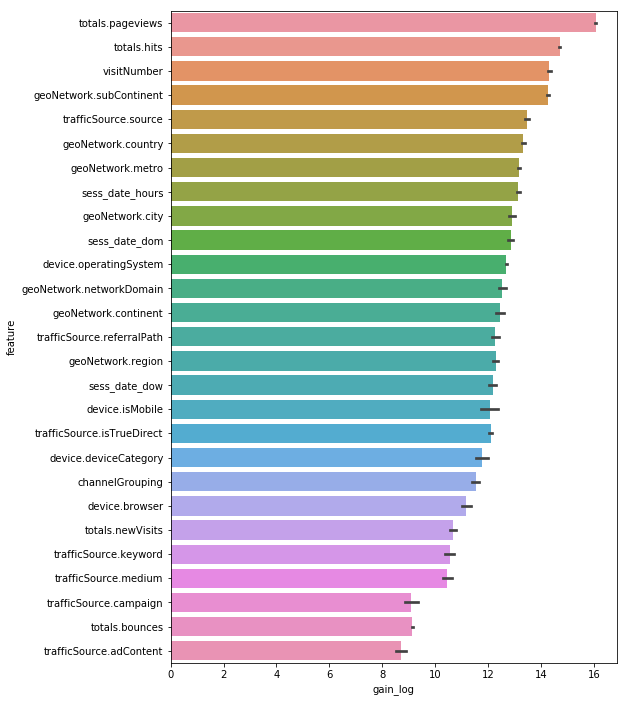

In [17]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

### Create user level predictions

In [36]:
train['predictions'] = np.expm1(oof_reg_preds)# out of fold,train on 80% of data, predict other 20% x 5
test['predictions'] = sub_reg_preds #ave(5 folds, use best fit to predict on all of test data)

In [37]:
# Aggregate data at User level
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [38]:
trn_data.head()

,channelGrouping,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,...,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,69.0,1.0,...,-1.0,0.0,NaN,0.0,0.0,-1.0,0.0,4.0,5.0,21.0
0000020424342248747,0.0,1.0,0.0,0.0,0.0,0.0,46.0,3.0,42.0,0.0,...,-1.0,0.0,NaN,0.0,0.0,-1.0,0.0,3.0,7.0,1.0
0000027376579751715,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,33.0,1.0,...,-1.0,0.0,NaN,0.0,0.0,-1.0,0.0,6.0,2.0,12.0
0000039460501403861,6.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,11.0,1.0,...,-1.0,0.0,NaN,-1.0,1.0,72.0,25.0,0.0,15.0,27.0
0000040862739425590,2.0,1.5,0.0,0.0,0.0,1.0,111.0,3.0,33.0,3.0,...,-1.0,1.0,1.0,13.0,2.0,-1.0,0.0,5.0,18.0,11.0


In [39]:
%%time
# Create a list of predictions for each Visitor
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

CPU times: user 27.7 s, sys: 160 ms, total: 27.9 s
Wall time: 27.9 s


In [42]:
train[['fullVisitorId', 'predictions']].head(1000).groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

fullVisitorId
0005096736076850458                                      {'pred_0': 0.0}
0015065858137292339                     {'pred_0': 0.014368145639969396}
0018131669611141208                       {'pred_0': 0.5091941841459183}
0019595737093157672                        {'pred_0': 80.17896037209007}
0042187268246961920                                      {'pred_0': 0.0}
0057228682567989873                       {'pred_0': 0.8392808420177446}
0063191589012692475                                      {'pred_0': 0.0}
010089030391699708                     {'pred_0': 0.0036372982003840745}
0113895825226302532                                      {'pred_0': 0.0}
0129431257283813068                     {'pred_0': 0.023366492396325222}
0131151074734304934                     {'pred_0': 0.009824860952351156}
0131179127719119947                                      {'pred_0': 0.0}
0185467632009737931    {'pred_0': 1.0128622280599109, 'pred_1': 35.12...
0222416580106802736                  

In [46]:
# Create a DataFrame with VisitorId as index
# trn_pred_list contains dict 
# so creating a dataframe from it will expand dict values into columns
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions
gc.collect()
full_data.shape

(714167, 310)

In [49]:
full_data.head()

,channelGrouping,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,...,pred_95,pred_96,pred_97,pred_98,pred_99,t_mean,t_median,t_sum_log,t_sum_act,t_nb_sess
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,69.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,277
0000020424342248747,0.0,1.0,0.0,0.0,0.0,0.0,46.0,3.0,42.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,277
0000027376579751715,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,33.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.004820,0.004820,0.004820,0.004820,277
0000039460501403861,6.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,11.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.000014,0.000014,0.000014,0.000014,277
0000040862739425590,2.0,1.5,0.0,0.0,0.0,1.0,111.0,3.0,33.0,3.0,...,NaN,NaN,NaN,NaN,NaN,0.006622,0.006622,0.013238,0.013200,276


In [50]:
%%time
sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

CPU times: user 24.4 s, sys: 140 ms, total: 24.5 s
Wall time: 23.8 s


In [51]:
sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape

(617242, 310)

### Create target at Visitor level

In [52]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

### Train a model at Visitor level

In [54]:
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5

[     0      1      2 ... 714164 714165 714166]
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2.37341	TRAIN's rmse: 1.54059	VALID's l2: 2.50652	VALID's rmse: 1.5832
Early stopping, best iteration is:
[132]	TRAIN's l2: 2.3265	TRAIN's rmse: 1.52529	VALID's l2: 2.50196	VALID's rmse: 1.58176
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2.3665	TRAIN's rmse: 1.53834	VALID's l2: 2.51758	VALID's rmse: 1.58669
Early stopping, best iteration is:
[128]	TRAIN's l2: 2.32703	TRAIN's rmse: 1.52546	VALID's l2: 2.5115	VALID's rmse: 1.58477
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2.36064	TRAIN's rmse: 1.53644	VALID's l2: 2.53618	VALID's rmse: 1.59254
[200]	TRAIN's l2: 2.25517	TRAIN's rmse: 1.50172	VALID's l2: 2.53228	VALID's rmse: 1.59131
Early stopping, best iteration is:
[157]	TRAIN's l2: 2.28981	TRAIN's rmse: 1.51321	VALID's l2: 2.53108	VALID's rmse: 1.59094
Training until validation scores do

1.583744448178488

### Display feature importances

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


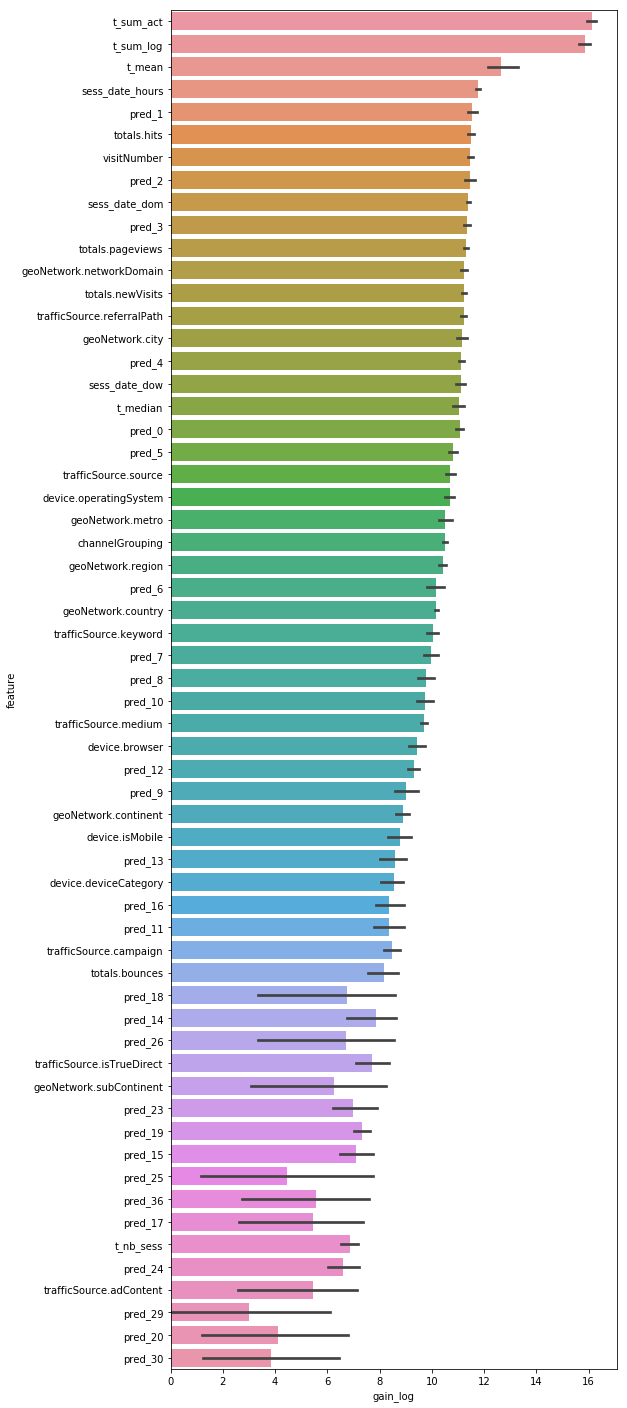

In [55]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

### Save predictions

In [27]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('new_test.csv', index=True)